# Collision Term

## EOM:

$$
\begin{cases}
    \dot{\textbf{P}} = \omega \textbf{B} \times \textbf{P}+ \mu (\textbf{P}-\bar{\textbf{P}}) \times \textbf{P} - \Gamma^{CC}_+ \textbf{P}_T + \Gamma^{AE}_+ (\textbf{P}^{AE} - \textbf{P}) + \Gamma^{AE}_- (P^{AE}_0 -P_0)\textbf{z} \\
    \dot{\bar{\textbf{P}}} = -\omega \textbf{B} \times \bar{\textbf{P}}+ \mu (\textbf{P}-\bar{\textbf{P}}) \times \bar{\textbf{P}} - \bar{\Gamma}^{CC}_+ \bar{\textbf{P}}_T + \bar{\Gamma}^{AE}_+ (\bar{\textbf{P}}^{AE} - \bar{\textbf{P}}) + \bar{\Gamma}^{AE}_- (\bar{P}^{AE}_0 -\bar{P}_0)\textbf{z} \\
    \dot{P_0} = \Gamma^{AE}_+ (P^{AE}_0 -P_0) + \Gamma^{AE}_- (P^{AE}_z -P_z) \\
    \dot{\bar{P}_0} = \bar{\Gamma}^{AE}_+ (\bar{P}^{AE}_0 -\bar{P}_0) + \bar{\Gamma}^{AE}_- (\bar{P}^{AE}_z -\bar{P}_z)
\end{cases}
$$

We choose the parameters
$$
\begin{bmatrix}
\omega \\ \textbf{B} \\ \mu \\ \theta
\end{bmatrix}
= \begin{bmatrix}
0.3 ~km^{-1} \\ -sin 2\theta~\textbf{e}_x^f + cos 2\theta~\textbf{e}_z^f \\ 6 \times 10^5 ~km^{-1} \\ 10^{-6}
\end{bmatrix}
$$

$$
\begin{bmatrix}
\Gamma^{CC}_+ \\ \Gamma^{AE}_+ \\ \Gamma^{AE}_-
\end{bmatrix}
= \begin{bmatrix}
0.5/11.4 ~km^{-1} \\ 0.5/0.417 ~km^{-1} \\ 0.5/0.417 ~km^{-1}
\end{bmatrix}
$$

$$
\begin{bmatrix}
\bar{\Gamma}^{CC}_+ \\ \bar{\Gamma}^{AE}_+ \\ \bar{\Gamma}^{AE}_-
\end{bmatrix}
= \begin{bmatrix}
0.5/37.2 ~km^{-1} \\ 0.5/4.36 ~km^{-1} \\ 0.5/4.36 ~km^{-1} 
\end{bmatrix}
$$

$$
\begin{bmatrix}
\textbf{P}^{AE} \\ P^{AE}_0 \\ \bar{\textbf{P}}^{AE} \\ \bar{P}^{AE}_0
\end{bmatrix}
= \begin{bmatrix}
2 ~\textbf{e}_z^f\\ 4 \\ 1.5 ~\textbf{e}_z^f \\ 3.5
\end{bmatrix}
$$

and theinitial condition
$$
\begin{bmatrix}
\textbf{P} \\ P_0 \\ \bar{\textbf{P}} \\ \bar{P}_0
\end{bmatrix}
= \begin{bmatrix}
2 ~\textbf{e}_z^f\\ 4 \\ 1.5 ~\textbf{e}_z^f \\ 3.5
\end{bmatrix}
$$

## Numerical Simulation
With the above information, we are able to do the numerical simulation below

In [1]:
using LinearAlgebra
using DifferentialEquations, StaticArrays
using Plots
using Base.Threads

#parameters
const w_0 = 0.3 #km^-1
const gcc = 0.5/11.4 #km^-1
const gaep = 0.5/0.417#km^-1
const gaem = 0.5/0.417#km^-1
PAE = SA[0.0,0.0,2.0]
const PAEZ = PAE[3]
const PAE0 = 4.0

const bgcc = 0.5/37.2 #km^-1
const bgaep = 0.5/4.36 #km^-1
const bgaem = 0.5/4.36 #km^-1
bPAE = SA[0.0,0.0,1.5]
const bPAEZ = bPAE[3]
const bPAE0 = 3.5

#initial P_w
Pi = [0.0,0.0,2.0]
const Pi0 = 4.0
bPi = [0.0,0.0,1.5] #P_bar
const bPi0 = 3.5

#range
mu_0s = [[6*10^i for i = 2:0.01:3.5]; [6*10^i for i = 3.6:0.1:5]]
thetas = [[10^i for i = -6:0.1:-3.6]; [10^i for i = -3.5:0.01:-2]]
print()

In [ ]:
#EOM
function EQ3(u,p,t)
    #u = (P,P_bar,P_0,P_bar0)
    P = SVector{3}(u[1:3])::SVector{3, Float64}
    bP = SVector{3}(u[4:6])::SVector{3, Float64}
    P_0 = u[7]::Float64
    bP_0 = u[8]::Float64
    PT = SVector{3}([P[1:2];0.0])::SVector{3, Float64}
    bPT = SVector{3}([bP[1:2];0.0])::SVector{3, Float64}
    
    #parameters
    wB,PAE,bPAE,mu_0,theta = p
    
    #du/dt
    du = Vector{Float64}(undef, 8)
    du[1:3] = cross(wB-mu_0*bP,P)-gcc*PT+gaep*(PAE-P)
    du[3] += gaem*(PAE0-P_0)
    du[4:6] = cross(-wB+mu_0*P,bP)-bgcc*bPT+bgaep*(bPAE-bP)
    du[6] += bgaem*(bPAE0-bP_0)
    du[7] = gaep*(PAE0-P_0)+gaem*(PAEZ-P[3])
    du[8] = bgaep*(bPAE0-bP_0)+bgaem*(bPAEZ-bP[3])

    du_sv = SVector{8}(du)::SVector{8, Float64}
end

function main(mu_0, theta)
    #B= SA[-sin(2*theta),0,cos(2*theta)]
    @fastmath @inbounds wB = w_0*SA[-sin(2*theta),0,cos(2*theta)]

    #solver
    # initial values
    u0 = SVector{8}([Pi;bPi;Pi0;bPi0])
    tspan = (0.0, 7.0)
    prob = ODEProblem(EQ3,u0,tspan,SA[wB,PAE,bPAE,mu_0,theta])
    #return (solve(prob,Vern7(),reltol=1e-13, abstol=1e-13, maxiters=1e14,saveat=0.01))
    return (solve(prob,Vern7(),reltol=1e-15, abstol=1e-15, maxiters=1e30,saveat=0.01))
end

#mu_0 = 6.0e5 #6e5 km^-1
#theta = 1.0e-6 #1e-6
rho_p = 0.01
#analytic
S=Pi[3] + bPi[3]
D=Pi[3] - bPi[3]
g = gcc+gaep #gamma
bg = bgcc+bgaep #gamma_bar

num_tp = Vector{Float64}(undef, length(mu_0s)*length(thetas))
ana_tp = Vector{Float64}(undef, length(mu_0s)*length(thetas))
time_elapsed = @elapsed @threads for i in 1:length(mu_0s)*length(thetas)
    mu_i = rem(i-1,length(mu_0s)) + 1
    theta_i = div(i-1,length(mu_0s)) + 1
    sol = main(mu_0s[mu_i], thetas[theta_i])
    rho = 0.5sol[1,:]+0.5im*sol[2,:] #rho_ex = Px+i Py
    brho = 0.5sol[4,:]+0.5im*sol[5,:] #bar{rho}_ex = bPx+i bPy
    absrho = (broadcast(abs,rho).^2 .+ broadcast(abs,brho).^2).^0.5
    for j in 1:length(sol.t)
        if absrho[j]>rho_p
            num_tp[i] = 10/3*sol.t[j] #num
            ana_tp[i] = 10/3*log(rho_p*mu_0s[mu_i]*D^2/2/thetas[theta_i]/w_0/S)/(0.5S*(g-bg)/D-0.5(g+bg)) #ana
            break
        end
    end
end

using JLD
using FileIO
#save data to file
save("J_CollisionTerm_tp.jld", "num_tp", num_tp, "ana_tp", ana_tp, "time_elapsed",time_elapsed)

In [2]:
using JLD
using FileIO
num_tp = reshape(load("J_CollisionTerm_tp.jld")["num_tp"], length(mu_0s), length(thetas))
ana_tp = reshape(load("J_CollisionTerm_tp.jld")["ana_tp"], length(mu_0s), length(thetas))
time_elapsed = load("J_CollisionTerm_tp.jld")["time_elapsed"]
print(time_elapsed)

226353.069988416

┌ Info: Saved animation to 
│   fn = /Users/lin/Ipython/t_p.gif
└ @ Plots /Users/lin/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/lin/Ipython/t_p.gif")
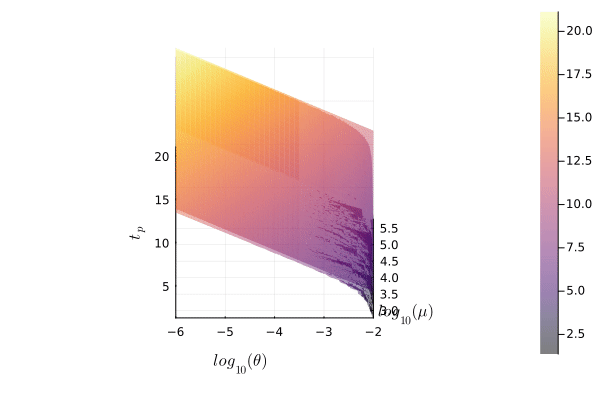

In [3]:
using Plots
using LaTeXStrings
#surface(, mu_0s, num_tp)
anim = @animate for i in range(0, stop = 360, length = 100)
    plot(broadcast(log10,thetas),broadcast(log10,mu_0s),num_tp,st=:surface, alpha = 0.5)
    plot!(broadcast(log10,thetas),broadcast(log10,mu_0s),ana_tp,st=:surface, ylabel=L"log_{10}(\mu)", xlabel=L"log_{10}(\theta)",zlabel=L"t_p", camera=(i, 30), alpha = 0.5)
end
gif(anim, "t_p.gif", fps = 120)

In [54]:
#plot final result
using LaTeXStrings
using Plots
using Printf
theta_i = 1 #1~41
@fastmath @inbounds x = mu_0s
@fastmath @inbounds y = [num_tp[:, theta_i] ana_tp[:, theta_i]]
plot(x, y, xlabel = L"\mu/\mathrm{km^{-1}}", ylabel = L"t / \mathrm{\mu s}", title=L"t_p ~(\theta=" * @sprintf("%.2E", thetas[theta_i]) * L")", label = ["num" "ana"], dpi = 300, legend=:bottomright)
savefig("compare_tp_mu_nonlog.png")

In [55]:
#log_x
plot(x, y, xlabel = L"\mu/\mathrm{km^{-1}}", ylabel = L"t / \mathrm{\mu s}", title=L"t_p ~(\theta=" * @sprintf("%.2E", thetas[theta_i]) * L")",label = ["num" "ana"], xaxis=:log, dpi = 300, legend=:bottomright)
savefig("compare_tp_mu.png")

In [56]:
#plot final result
using LaTeXStrings
using Plots
using Printf
mu_i = 166 #1~31
@fastmath @inbounds x = thetas
@fastmath @inbounds y = [num_tp[mu_i,:] ana_tp[mu_i,:]]
plot(x, y, xlabel = L"\theta",ylabel = L"t / \mathrm{\mu s}", title=L"t_p ~(\mu=" * @sprintf("%.2E", mu_0s[mu_i]) * L"~\mathrm{km^{-1}})", label = ["num" "ana"], dpi = 300)
savefig("compare_tp_theta_nonlog.png")

In [57]:
#log_x
plot(x, y, xlabel = L"\theta",ylabel = L"t / \mathrm{\mu s}", title=L"t_p ~(\mu=" * @sprintf("%.2E", mu_0s[mu_i]) * L"~\mathrm{km^{-1}})", label = ["num" "ana"], xaxis=:log, dpi = 300)
savefig("compare_tp_theta.png")

## Linearlized EOM
Ignoring nonlinear terms, we have

$$
\begin{cases}
    i \partial_t \rho_{ex} = \omega ~sin2\theta P_{z}
    +\left[-\omega ~cos2\theta-\sqrt{2}G_F(n_{\bar{\nu_e}}-n_{\bar{\nu_x}})- i \Gamma \right]\rho_{ex} + \sqrt{2}G_F(n_{\nu_e}-n_{\nu_x}) \bar{\rho}_{ex}\\
    i \partial_t \bar{\rho}_{ex} = - \omega ~sin2\theta \bar{P}_{z} +\left[+\omega ~cos2\theta + \sqrt{2}G_F(n_{\nu_e}-n_{\nu_x}) - i \bar{\Gamma} \right]\bar{\rho}_{ex} -\sqrt{2}G_F(n_{\bar{\nu_e}}-n_{\bar{\nu_x}}) \rho_{ex}
\end{cases}
$$,
where
$$
\begin{cases}
B \equiv (sin 2\theta,0 ,cos 2\theta)
\\
\rho_{ex} \equiv \rho_{21} = P_x+i P_y
\\
\bar{\rho}_{ex} \equiv \bar{\rho}_{21} = \bar{P}_x+i \bar{P}_y
\\
\Gamma \equiv \Gamma^{AE} + \Gamma^{CC}
\\
\bar{\Gamma} \equiv \bar{\Gamma}^{AE} + \bar{\Gamma}^{CC}
\end{cases}
$$

Let
$$
\begin{cases}
\mu_+ \equiv \left(\frac{S+D}{2}\right) \mu
\\
\mu_- \equiv \left(\frac{S-D}{2}\right) \mu
\end{cases}
$$
and
$$
A = \begin{bmatrix}
-\omega ~cos2\theta-\mu_--i\Gamma ~~~~~~~~~~~~~~~~~~ \mu_+ ~~~~~~~~~~~~~~~~\\ ~~~~~~~~~~~ -\mu_- ~~~~~~~~~~~~~~~ \omega ~cos2\theta+\mu_+-i\bar{\Gamma}
\end{bmatrix}
$$
, we have
$$
i \partial_t \begin{bmatrix}
\rho_{ex} \\ \bar{\rho}_{ex}
\end{bmatrix} =
\begin{bmatrix}
\omega ~sin2\theta \\ - \omega ~sin2\theta
\end{bmatrix} + A \begin{bmatrix}
\rho_{ex} \\ \bar{\rho}_{ex}
\end{bmatrix}
$$
when $P_{z}$ and $\bar{P}_{z}$ close to 1.

Assume
$$
\begin{cases}
\rho_{ex}(t) = \rho^0_{ex} + Q e^{-i\Omega t}
\\
\bar{\rho}_{ex}(t) = \bar{\rho}^0_{ex} + \bar{Q} e^{-i\Omega t}
\end{cases}
$$, where $\rho^0_{ex}$ and $\bar{\rho}^0_{ex}$ satisfy
$$
0= \begin{bmatrix}
\omega ~sin2\theta \\ - \omega ~sin2\theta
\end{bmatrix}  + 
A \begin{bmatrix} \rho^0_{ex} \\ \bar{\rho}^0_{ex}
\end{bmatrix}
$$
, then
$$
\Omega 
\begin{bmatrix}
Q \\ \bar{Q}
\end{bmatrix}
= A
\begin{bmatrix}
Q \\ \bar{Q}
\end{bmatrix}
$$

### Aproximation (not used in this simulation)

For $\theta \ll 1$ and $P_x~,P_y \ll P_z$, we have
$$
\begin{cases}
    i \partial_t \rho_{ex} = 2\omega\theta
    +\left[-\omega-\sqrt{2}G_F(n_{\bar{\nu_e}}-n_{\bar{\nu_x}})- i \Gamma \right]\rho_{ex} + \sqrt{2}G_F(n_{\nu_e}-n_{\nu_x}) \bar{\rho}_{ex}\\
    i \partial_t \bar{\rho}_{ex} = - 2\omega\theta +\left[+\omega + \sqrt{2}G_F(n_{\nu_e}-n_{\nu_x}) - i \bar{\Gamma} \right]\bar{\rho}_{ex} -\sqrt{2}G_F(n_{\bar{\nu_e}}-n_{\bar{\nu_x}}) \rho_{ex}
\end{cases}
$$

Then,
$$
\Omega 
\begin{bmatrix}
Q \\ \bar{Q}
\end{bmatrix}
= 
\begin{bmatrix}
-\omega-\mu_--i\Gamma ~~~~ \mu_+ ~~~~~~~~~~~~~~~~\\ -\mu_- ~~~~~~~~~~~~~~~~~~~~ \omega+\mu_+-i\bar{\Gamma}
\end{bmatrix}
\begin{bmatrix}
Q \\ \bar{Q}
\end{bmatrix}
$$

Under the assumption that $\mu S, \mu D>> \omega >>\gamma$, we have the eigenvalue of the above equation is
$$
\begin{cases}
\Omega_+ \simeq \mu D + i\left[ -\frac{1}{2}(\Gamma + \bar{\Gamma}) + \frac{S}{2 D}(\Gamma - \bar{\Gamma})\right]
\\
\Omega_- \simeq \frac{\omega S}{D} + i\left[ -\frac{1}{2}(\Gamma + \bar{\Gamma}) - \frac{S}{2 D}(\Gamma - \bar{\Gamma})\right]
\end{cases}
$$
Notice that for + mode,
$$
Q_+ \simeq \bar{Q}_+
$$
; for - mode,
$$
Q_- \simeq \frac{S+D}{S-D}\bar{Q}_-
$$

### Draw the proportions of each mode with eigenvalues and eigenvectors
First, we have to find the eigenvalues of matrix $A$, and denote the eigenvalues and normalized eigenvectors as $\Omega_\pm$ and $\vec{v}_\pm$.

Then,
$$
\begin{bmatrix}
\rho_{ex} (t)\\ \bar{\rho}_{ex} (t)
\end{bmatrix}
= \begin{bmatrix} 
\rho^0_{ex} \\ \bar{\rho}^0_{ex}
\end{bmatrix} + 
Q_+ \vec{v}_+
e^{-i \Omega_{+} ~\bf{t}} +
Q_- \vec{v}_-
e^{-i \Omega_{-} ~\bf{t}}
=
\begin{bmatrix}
\vec{v}_- ~~ \vec{v}_+
\end{bmatrix}
\begin{bmatrix}
Q_-e^{-i \Omega_{-} ~\bf{t}} \\ Q_+e^{-i \Omega_{+} ~\bf{t}}
\end{bmatrix} + 
\begin{bmatrix} 
\rho^0_{ex} \\ \bar{\rho}^0_{ex}
\end{bmatrix}
$$, or
$$
\begin{bmatrix}
Q_-e^{-i \Omega_{-} ~\bf{t}} \\ Q_+e^{-i \Omega_{+} ~\bf{t}}
\end{bmatrix} =
\begin{bmatrix}
\vec{v}_- ~~ \vec{v}_+
\end{bmatrix}^{-1}
\begin{bmatrix}
\rho_{ex} (t) - \rho^0_{ex} \\ \bar{\rho}_{ex} (t) -\bar{\rho}^0_{ex}
\end{bmatrix}
$$

## Comparing the proportions of each mode with eigenvalues and eigenvectors
From the above discussion, we are able to do a analytic simulation

$$
\begin{bmatrix}
\rho_{ex} (t)\\ \bar{\rho}_{ex} (t)
\end{bmatrix}
=
\begin{bmatrix}
\vec{v}_- ~~ \vec{v}_+
\end{bmatrix}
\begin{bmatrix}
Q_-e^{-i \Omega_{-} ~\bf{t}} \\ Q_+e^{-i \Omega_{+} ~\bf{t}}
\end{bmatrix} + 
\begin{bmatrix} 
\rho^0_{ex} \\ \bar{\rho}^0_{ex}
\end{bmatrix}
$$, where $Q_-$ and $Q_+$ satisfy
$$
\begin{bmatrix}
Q_- \\ Q_+
\end{bmatrix} =
\begin{bmatrix}
\vec{v}_- ~~ \vec{v}_+
\end{bmatrix}^{-1}
\begin{bmatrix}
\rho_{ex} (0) - \rho^0_{ex} \\ \bar{\rho}_{ex} (0) -\bar{\rho}^0_{ex}
\end{bmatrix}=
\begin{bmatrix}
\vec{v}_- ~~ \vec{v}_+
\end{bmatrix}^{-1}
\begin{bmatrix}
- \rho^0_{ex} \\ -\bar{\rho}^0_{ex}
\end{bmatrix}
$$

## Draw the proportions of each mode with differential method

Notice that
$$
\begin{bmatrix}
\rho_{ex} (t)\\ \bar{\rho}_{ex} (t)
\end{bmatrix}
= 
\begin{bmatrix}
Q_+ \\ \bar{Q}_+
\end{bmatrix}
e^{-i \Omega_{+} ~\bf{t}} + 
\begin{bmatrix}
Q_- \\ \bar{Q}_-
\end{bmatrix}
e^{-i \Omega_{-} ~\bf{t}}
$$, or
$$
\begin{bmatrix}
\dot{\rho_{ex}} (t)\\ \dot{\bar{\rho}}_{ex} (t)
\end{bmatrix}
= 
-i \Omega_{+} \begin{bmatrix}
Q_+ \\ \bar{Q}_+
\end{bmatrix}
e^{-i \Omega_{+} ~\bf{t}} - 
i \Omega_{-}
\begin{bmatrix}
Q_- \\ \bar{Q}_-
\end{bmatrix}
e^{-i \Omega_{-} ~\bf{t}}
$$, where we assume the variation of Q is a quasistatic process.

Therefore,
$$
\begin{cases}
\left|Q_+\right| = \left|\left(\frac{i\Omega_- ~ \rho_{ex} ~+ \dot{\rho}_{ex}}{\Omega_+ - \Omega_-}\right) e^{i \Omega_{+} ~\bf{t}}\right|
\\
\left|Q_-\right| =  \left|\left(\frac{i\Omega_+ ~ \rho_{ex} ~+ \dot{\rho}_{ex}}{\Omega_+ - \Omega_-}\right) e^{i \Omega_{-} ~\bf{t}}\right|
\\
\left|\bar{Q}_+\right| = \left|\left(\frac{i\Omega_- ~ \bar{\rho}_{ex} ~+ \dot{\bar{\rho}}_{ex}}{\Omega_+ - \Omega_-}\right) e^{i \Omega_{+} ~\bf{t}}\right|
\\
\left|\bar{Q}_-\right| = \left|\left(\frac{i\Omega_+ ~ \bar{\rho}_{ex} ~+ \dot{\bar{\rho}}_{ex}}{\Omega_+ - \Omega_-}\right) e^{i \Omega_{-} ~\bf{t}}\right|
\end{cases}
$$, or
$$
\begin{cases}
Q_+^2 \equiv \left|Q_+\right|^2 + \left|\bar{Q}_+\right|^2 \\= 
\left|\left(\frac{i\Omega_- ~ \rho_{ex} ~+ \dot{\rho}_{ex}}{\Omega_+ - \Omega_-}\right) e^{i \Omega_{+} ~\bf{t}}\right| +
\left|\left(\frac{i\Omega_- ~ \bar{\rho}_{ex} ~+ \dot{\bar{\rho}}_{ex}}{\Omega_+ - \Omega_-}\right) e^{i \Omega_{+} ~\bf{t}}\right|^2
\\
Q_-^2 \equiv \left|Q_-\right|^2 + \left|\bar{Q}_-\right|^2 \\= 
\left|\left(\frac{i\Omega_+ ~ \rho_{ex} ~+ \dot{\rho}_{ex}}{\Omega_+ - \Omega_-}\right) e^{i \Omega_{-} ~\bf{t}}\right| +
\left|\left(\frac{i\Omega_+ ~ \bar{\rho}_{ex} ~+ \dot{\bar{\rho}}_{ex}}{\Omega_+ - \Omega_-}\right) e^{i \Omega_{-} ~\bf{t}}\right|^2
\end{cases}
$$